In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install featuretools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.0/618.0 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 15.8 MB/s eta 0:00:00


In [ ]:
# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature engineering
import featuretools as ft
from featuretools import selection

# Data Augmentation
from imblearn.over_sampling import SMOTE

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import ElasticNet
from xgboost import plot_importance

# Librairies graphiques
import plotly.offline as py
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

1. **Description des données**

In [ ]:
# Lecture des données
train_set = pd.read_csv('application_train.csv').sort_values("SK_ID_CURR")
test_set = pd.read_csv('application_test.csv').sort_values("SK_ID_CURR")
bureau = pd.read_csv("bureau.csv").sort_values(['SK_ID_CURR', 'SK_ID_BUREAU'])
bureau_balance = pd.read_csv("bureau_balance.csv").sort_values("SK_ID_BUREAU")
cash_balance = pd.read_csv("POS_CASH_balance.csv").sort_values([
    'SK_ID_CURR', 'SK_ID_PREV'])
card_balance = pd.read_csv('credit_card_balance.csv').sort_values([
    'SK_ID_CURR', 'SK_ID_PREV'])
prev_app = pd.read_csv('previous_application.csv').sort_values(
    ['SK_ID_CURR', 'SK_ID_PREV'])
payments = pd.read_csv('installments_payments.csv').sort_values(
    ['SK_ID_CURR', 'SK_ID_PREV'])

In [ ]:
# Affiche les 5 premières lignes des données d'entrainement
train_set.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
6710456,6,NaN,NaN
2846398,5001710,-82.0,X
2846397,5001710,-81.0,X
2846396,5001710,-80.0,X
2846395,5001710,-79.0,X


In [ ]:
#Structure des données
def describe_columns_df(df):
    """
    Affiche la description détaillée du contenu de chaque colonne de df
    df(pd.Dataframe): jeu de données
    """
    for col in df:
        print(col)
        null = df[col].isnull().sum()
        # affiche le nombre de valeurs manquantes
        print('Number of empty : ', null)
        # affiche le pourcentage de valeurs manquantes
        print('Percent of empty : ', 100*null/df.shape[0])
        print(df[col].describe())
        if df[col].dtype == object:
            print('Categories and Count:')
            print(df[col].value_counts().to_string(header=None))
        print('\n')

pour afficher des informations détaillées sur chaque colonne, y compris le nombre de valeurs manquantes, le pourcentage de valeurs manquantes, la description statistique et les catégories uniques (uniquement pour les colonnes de type objet).

In [ ]:
# Affiche la description détaillée du contenu
# de chaque colonne du jeu d'entrainement
describe_columns_df(train_set)

SK_ID_CURR
Number of empty :  0
Percent of empty :  0.0
count    164999.000000
mean     195683.454603
std       55218.947585
min      100002.000000
25%      147757.500000
50%      195676.000000
75%      243510.500000
max      291271.000000
Name: SK_ID_CURR, dtype: float64


TARGET
Number of empty :  0
Percent of empty :  0.0
count    164999.000000
mean          0.081485
std           0.273580
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64


NAME_CONTRACT_TYPE
Number of empty :  0
Percent of empty :  0.0
count         164999
unique             2
top       Cash loans
freq          149329
Name: NAME_CONTRACT_TYPE, dtype: object
Categories and Count:
Cash loans         149329
Revolving loans     15670


CODE_GENDER
Number of empty :  0
Percent of empty :  0.0
count     164999
unique         3
top            F
freq      108585
Name: CODE_GENDER, dtype: object
Categories and Count:
F      108585


Colonne:'TARGET'

In [ ]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

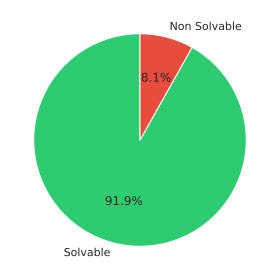

In [ ]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(train_set)

Dans le jeu de données analysé, il est observé que 92 % des prêts ont été remboursés, ce qui signifie que les individus associés à ces prêts étaient solvables. En revanche, 8 % des individus n'ont pas remboursé leur prêt, ce qui indique qu'ils étaient non solvables.

2. **Nettoyage des données**

In [ ]:
def merge_train_test(df_train, df_test):
    """
    Merge les jeu d'entrainement et de test en rajoutant
    une colonne 'Test' qui prend les valeurs True ou False
    df_train(pd.DataFrame): jeu d'entrainement
    df_test(pd.DataFrame): jeu test
    """

    df_train['Test'] = False
    df_test['Test'] = True
    df_test['TARGET'] = pd.NA  # Utilisation de pd.NA pour représenter les valeurs manquantes
    app = pd.concat([df_train, df_test], ignore_index=True, sort=False)
    return app


In [ ]:
# Merge jeu d'entrainement et jeu de test
app = merge_train_test(train_set, test_set)

2.1 Variables catégorielles

In [ ]:
def display_cat_columns(app):
    """
    Pour chaque colonne catégorielle, indique le nombre et le nom
    des différentes valeurs prises
    """

    for col in app:
        if app[col].dtype == object:
            print(col)
            print('Number Unique in Train:', app[~app['Test']][col].nunique())
            print('Number Unique in Test: ', app[app['Test']][col].nunique())
            print('Unique in Train: ',
                  sorted([str(e) for e in
                          app[~app['Test']][col].unique().tolist()]))
            print('Unique in Test: ',
                  sorted([str(e) for e in
                          app[app['Test']][col].unique().tolist()]))
            print('\n')

In [ ]:
# Descriptif des variables catégorielles
display_cat_columns(app)

TARGET
Number Unique in Train: 2
Number Unique in Test:  0
Unique in Train:  ['0', '1']
Unique in Test:  ['<NA>']


NAME_CONTRACT_TYPE
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['Cash loans', 'Revolving loans']
Unique in Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Number Unique in Train: 3
Number Unique in Test:  2
Unique in Train:  ['F', 'M', 'XNA']
Unique in Test:  ['F', 'M']


FLAG_OWN_CAR
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


FLAG_OWN_REALTY
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


NAME_TYPE_SUITE
Number Unique in Train: 7
Number Unique in Test:  7
Unique in Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique in Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INC

2.2 Variables numériques

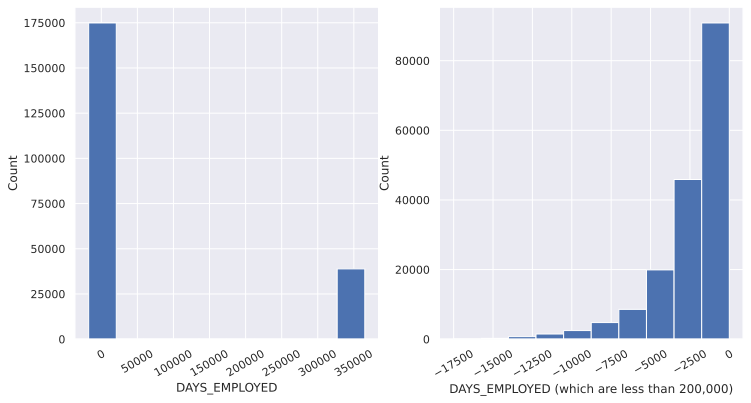

In [ ]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app.loc[app['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

 **- Traitement_de_variable_catégoriel**

Dans le jeu d'entraînement, nous avons observé certaines anomalies dans certaines colonnes catégorielles. Plus précisément :

1. Pour la colonne qui indique le genre des emprunteurs, nous avons remarqué que seules quatre valeurs étaient présentes et toutes étaient étiquetées comme 'XNA'. Ces valeurs semblent être des valeurs inconnues ou incorrectes, il a donc été décidé de supprimer les emprunts correspondants de notre jeu d'entraînement.

2. Dans la colonne 'NAME_INCOME_TYPE', nous avons constaté que la valeur 'Maternity leave' n'apparaissait que dans le jeu d'entraînement et seulement pour cinq emprunteurs. Étant donné que cette valeur est spécifique à la situation de congé maternité et qu'elle est rare, il a été décidé de supprimer les lignes correspondant à ces emprunts de notre jeu d'entraînement.

3. De manière similaire, dans la colonne 'NAME_FAMILY_STATUS', nous avons observé que la valeur 'Unknown' apparaissait seulement deux fois et uniquement dans le jeu d'entraînement. Comme il s'agit d'une valeur peu fréquente et qu'elle ne fournit pas d'informations significatives, les lignes correspondantes ont été supprimées de notre jeu d'entraînement.

Ces actions de suppression ont été entreprises pour nettoyer notre jeu d'entraînement en éliminant les valeurs non représentatives ou erronées dans ces colonnes catégorielles.

In [ ]:
# Supprime les individus dont le genre est 'XNA'
app = app[app['CODE_GENDER'] != 'XNA']
# Supprime les individus dont 'NAME_INCOME_TYPE' vient d'un congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']
# Supprime les individus dont la statut familial est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

*Détection et traitement des valeurs abérrantes*

In [ ]:
#Affiche les valeurs abérrantes
values_to_nan = app.loc[app['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


In [ ]:
# Remplace la valeur abérrante par NaN
app['DAYS_EMPLOYED'].replace(values_to_nan, np.nan, inplace=True)

In [ ]:
# Sauvegarde des résultats
app.to_csv("app_no_encoded_no_featureengineering.csv")

 **- Feature Engineering**